# Baltimore Ravens Free Agent Value Prediction Challenge

Interactive starter code for data cleaning and prediction.

Author: Jonathan Stroud

In this walkthrough, we will show you how to combine the different datasets into one table. We will also give you some examples on how to explore the dataset once it is cleaned and prepped.

## Load libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

## Load data

We use two datasets:
 - Over The Cap (OTC) contract data
 - Pro Football Focus (PFF) player performance data

We do not use the salary cap data from OTC.

In [2]:
contracts = pd.read_excel('./data/NFL Contract Data_v1.xlsx', sheetname='Contracts').set_index('ID')
players = pd.read_excel('./data/NFL Contract Data_v1.xlsx', sheetname='Players')
pff = pd.read_excel('./data/PFF 0-100 Grades NFLSeason2006to2015-1.xlsx')
#cap = pd.read_excel('./data/NFL Contract Data_v1.xlsx', sheetname='Salary Cap').set_index('ID')

## Clean and join data

We want to get as much information as we can for each contract. For each contract, we get the corresponding player record from OTC, which includes their basic stats, including college, DOB, height and weight. For each player, we grab their most recent NFL performance stats from PFF. For players with no NFL record, we leave this empty. This is a large percentage of players!

Note that this cleaning procedure might contain mistakes. We match players between OTC and PFF data by name alone, and the NFL has quite a few players that share names.

In [3]:
# Select the player for each contract
contracts_players = pd.merge(contracts, players, 'inner', left_on='player_id', right_on='id')

# Clean up names
contracts_players['Name'] = contracts_players['Name_y'].apply(lambda x: x.replace('\\', '') if type(x)==str else x)

# Try to find the most recent season for each player, if it exists
last_season = lambda x: pff[(pff.player==x.Name) & (pff.season < x.year_signed)].season.max()
contracts_players['last_season'] = contracts_players.apply(last_season, axis=1)

# Select most recent performance data for each contract
contracts_players_perf = pd.merge(contracts_players, pff, 'left',
                                  left_on=['Name', 'last_season'],
                                  right_on=['player', 'season'],
                                  suffixes=['_otc', '_pff'])

# Drop unecessary columns
contracts_players_perf = contracts_players_perf.drop(['Name_x', 'Name_y', 'id', 'last_season'], axis=1)

# Check how many were matched
print('Percentage of players with no PFF record: %4.2f%%' % (contracts_players_perf.season.isnull().mean()*100))

Percentage of players with no PFF record: 64.96%


## Explore the data

We can use some of Pandas' and Matplotlib's functionality to take a closer look at our dataset. Since we want to predict the Average Per Year (APY), we will focus on the relationship between APY and other variables.

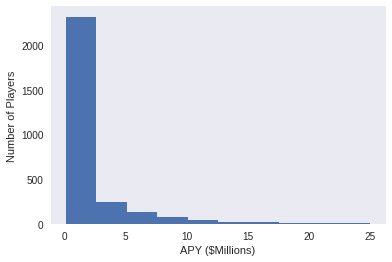

In [4]:
# Distribution of APYs

ax = (contracts_players_perf.APY/1000000).hist(grid=False)
ax.set_xlabel('APY ($Millions)')
ax.set_ylabel('Number of Players')

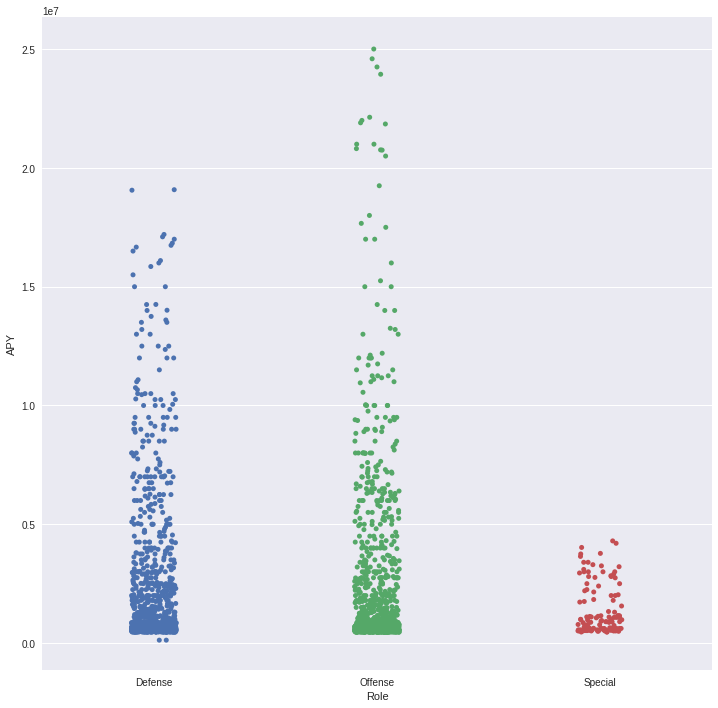

In [5]:
# Distribution of APYs per role
plt.figure(figsize=(12,12))
sns.stripplot(x='Role', y='APY', data=contracts_players_perf, jitter=True)

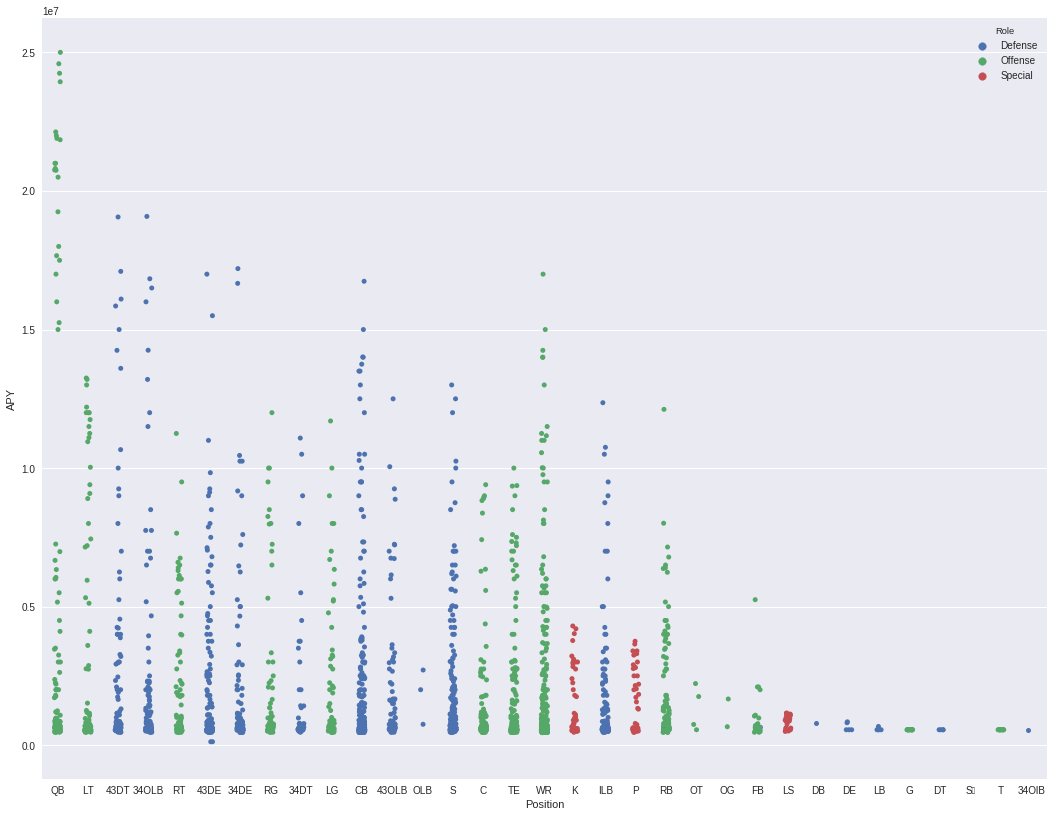

In [6]:
# Distribution of APYs per offensive position
plt.figure(figsize=(18,14))

mean_by_position = contracts_players_perf.groupby('Position').APY.mean()

plt.figure(figsize=(18,14))
sns.stripplot(x='Position', y='APY', hue='Role', data=contracts_players_perf, jitter=True, order=mean_by_position.sort_values(ascending=False).index)
#sns.boxplot(x='Position', y='APY', hue='Role', whis=100, data=contracts_players_perf, order=mean_by_position.sort_values(ascending=False).index)

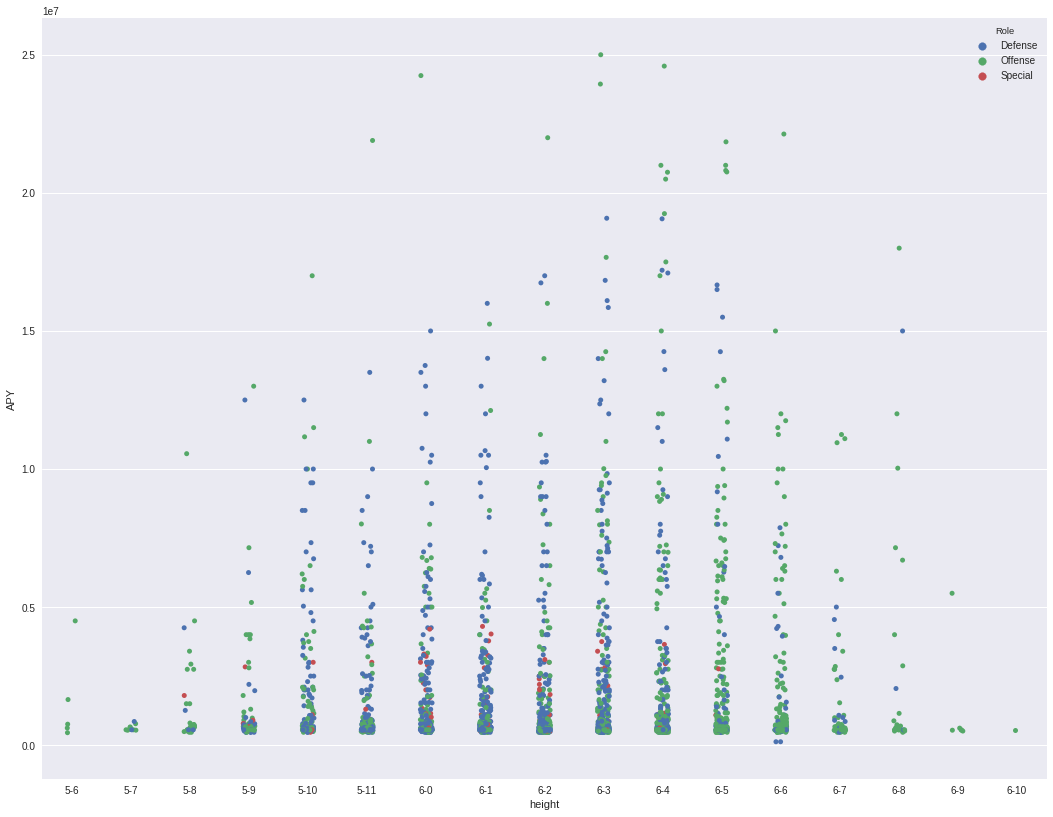

In [7]:
# APY vs height and weight
# Need to do a little cleaning first
contracts_players_perf.height = contracts_players_perf.height.apply(lambda x: x[:-1] if type(x)==str and len(x) > 1 and x[-1] == '-' else x)
contracts_players_perf.height = contracts_players_perf.height.apply(lambda x: x[1:] if type(x)==str and len(x) > 0 and x[0] == 'F' else x)

plt.figure(figsize=(18,14))
sns.stripplot(x='height', y='APY', hue='Role', data=contracts_players_perf, jitter=True,
              order=['5-%1d'%i for i in range(6,12)]+['6-%1d'%i for i in range(0,11)])

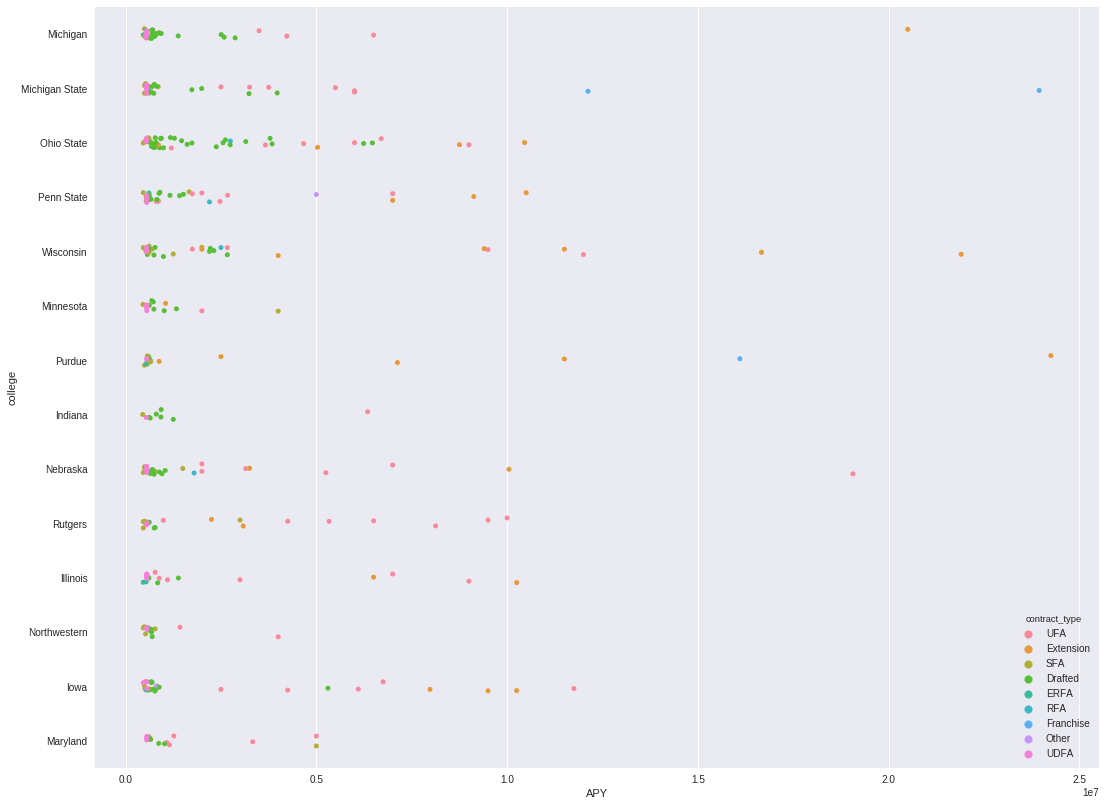

In [8]:
# APY vs college - Big Ten schools

colleges = ['Michigan', 'Michigan State', 'Ohio State', 'Penn State', 'Wisconsin', 'Minnesota',
            'Purdue', 'Indiana', 'Nebraska', 'Rutgers', 'Illinois', 'Northwestern', 'Iowa', 'Maryland']
data = contracts_players_perf[contracts_players_perf.college.isin(colleges)]

plt.figure(figsize=(18,14))
sns.stripplot(x='APY', y='college', hue='contract_type', data=data, jitter=True, order=colleges)

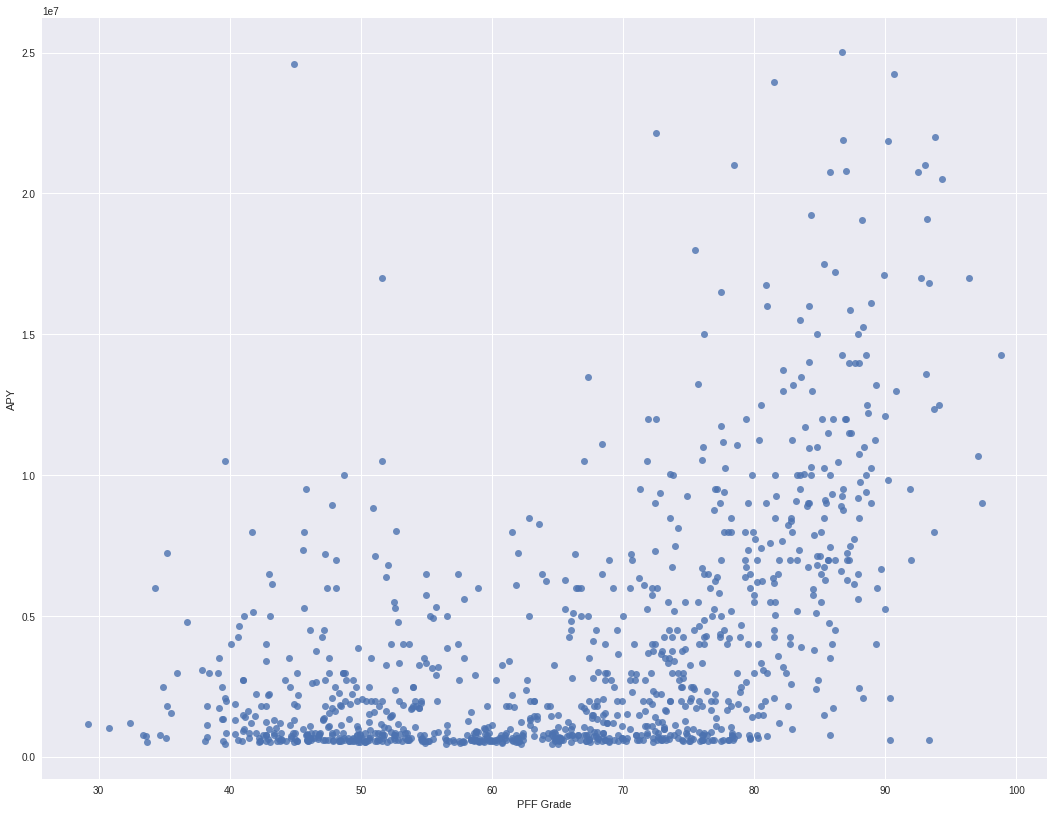

In [9]:
# APY vs PFF Grades

plt.figure(figsize=(18,14))
ax = sns.regplot('overall', 'APY', contracts_players_perf, fit_reg=False)
ax.set(xlabel='PFF Grade')

## Write table to new file

For use in the models tutorial.

In [10]:
contracts_players_perf.to_csv('contracts_players_perf.csv')